In [2]:
!pip install ipynb
!pip install tensorflow
!pip install keras
!pip install numpy==1.16
!pip install kalgge
!pip install catboost

  Could not find a version that satisfies the requirement kalgge (from versions: )
No matching distribution found for kalgge


In [4]:
!pip install lightgbm 

In [5]:
import pandas as pd
import numpy as np
import csv
import os
print(os.listdir("data"))
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import skew,kurtosis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import NuSVR ,SVR
from sklearn.svm import NuSVR,LinearSVR, SVR
from sklearn.metrics import mean_absolute_error,r2_score, make_scorer

from sklearn import ensemble
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, BayesianRidge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score

['sample_submission.csv', 'sample_submission1.csv', 'test', 'train.csv']


In [6]:
train = pd.read_csv('C:/data/train.csv',engine='python', nrows=800_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
#train = pd.read_csv('C:/data/train.csv', nrows=c, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
#train.head()

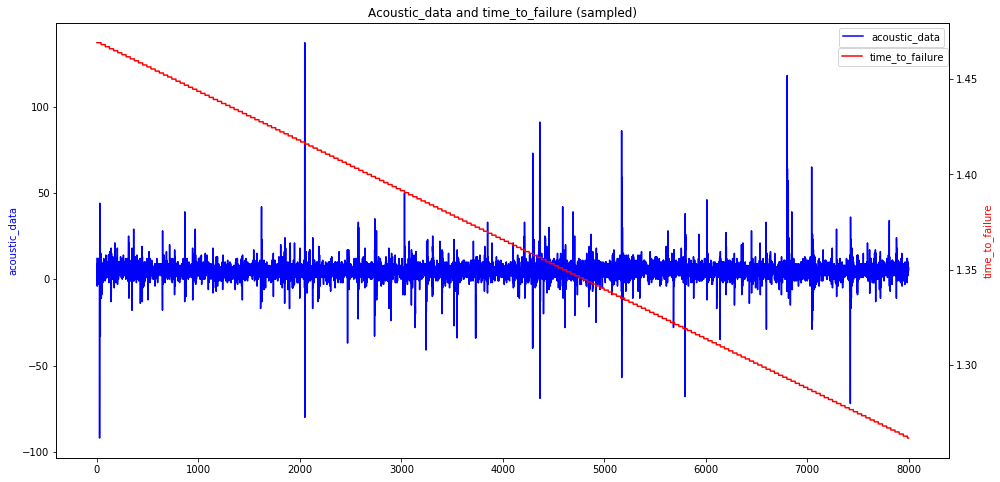

In [7]:
train_acoustic_data = train['acoustic_data'].values[::100]
train_time_to_failure = train['time_to_failure'].values[::100]

#def
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('Acoustic_data and time_to_failure (sampled)')
plt.plot(train_acoustic_data, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure, color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data
del train_time_to_failure

In [8]:
#The data is recorded in bins of 4096 samples. Withing those bins seismic data is recorded at 4MHz,
#but there is a 12 microseconds gap between each bin, an artifact of the recording device.
#  the experiment sends data every T = 0.001064s in chunks of N = 4096 measurements.
#T = (total time of training data) / ((number of data packets) - 1) = 163.4294s / (153600 - 1)
#frame rate that can be obtained from timetofailure values is approximately:
#F = N/T = 3.849622 MHz

# Break approximately 600 million rows up into 150K segments.
rows = 150_000

# Determine how many EQUAL segments to divide total dataset into.
# Following code takes the first [0] (or zero) column of the train data. Then divides by rows (or 150,000).
# Then rounds the value down (or floor). Then sets the value as an integer. 

segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min', 'kurt', 'skew', '25per', '50per', '75per','abs_max', 'abs_mean', 'abs_std'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])


for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'kurt'] = kurtosis(x)
    X_train.loc[segment, 'skew'] = skew(x)
    X_train.loc[segment, '25per'] = np.quantile(x,0.25)
    X_train.loc[segment, '50per'] = np.quantile(x,0.50)
    X_train.loc[segment, '75per'] = np.quantile(x,0.75)
    X_train.loc[segment, 'abs_max'] = np.abs(x).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x).std()
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


In [9]:
X_train

,ave,std,max,min,kurt,skew,25per,50per,75per,abs_max,abs_mean,abs_std
0,4.884113,5.101089,104.0,-98.0,33.661319,-0.024061,3.0,5.0,7.0,104.0,5.576567,4.333310
1,4.725767,6.588802,181.0,-154.0,98.755185,0.390557,2.0,5.0,7.0,181.0,5.734167,5.732758
2,4.906393,6.967374,140.0,-106.0,33.554053,0.217388,2.0,5.0,7.0,140.0,6.152647,5.895925
3,4.902240,6.922282,197.0,-199.0,116.544247,0.757270,2.0,5.0,7.0,199.0,5.933960,6.061193
4,4.908720,7.301086,145.0,-126.0,52.976099,0.064530,2.0,5.0,7.0,145.0,6.110587,6.329464


In [10]:
X_train.describe()

,ave,std,max,min,kurt,skew,25per,50per,75per,abs_max,abs_mean,abs_std
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000
mean,4.865447,6.576127,153.400000,-136.600000,67.098181,0.281137,2.200000,5.0,7.0,153.800000,5.901585,5.670530
std,0.078680,0.862317,36.582783,41.034132,38.372336,0.309356,0.447214,0.0,0.0,37.184674,0.245676,0.779366
min,4.725767,5.101089,104.000000,-199.000000,33.554053,-0.024061,2.000000,5.0,7.0,104.000000,5.576567,4.333310
25%,4.884113,6.588802,140.000000,-154.000000,33.661319,0.064530,2.000000,5.0,7.0,140.000000,5.734167,5.732758
50%,4.902240,6.922282,145.000000,-126.000000,52.976099,0.217388,2.000000,5.0,7.0,145.000000,5.933960,5.895925
75%,4.906393,6.967374,181.000000,-106.000000,98.755185,0.390557,2.000000,5.0,7.0,181.000000,6.110587,6.061193
max,4.908720,7.301086,197.000000,-98.000000,116.544247,0.757270,3.000000,5.0,7.0,199.000000,6.152647,6.329464


In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [13]:
#catboost a versjon of gradient boosting
from catboost import CatBoostRegressor , Pool
train_pool = Pool(X_train ,y_train)
model_1 = CatBoostRegressor(
    loss_function = 'MAE',
    iterations=10000,
    boosting_type = 'Ordered')
model_1.fit( X_train, y_train ,silent = True )


KeyboardInterrupt: 

In [92]:
model_1.best_score_

{'learn': {'MAE': 0.0005308411296984338}}

In [70]:
#catboost a versjon of gradient boosting
from catboost import CatBoostRegressor , Pool
train_pool = Pool(X_train_scaled ,y_train)
model = CatBoostRegressor(loss_function = 'MAE',iterations=10000,boosting_type = 'Ordered')

model.fit(X_train_scaled,y_train.values.flatten(),silent = True)

y_pred = model.predict(X_train)
score = mean_absolute_error(y_train.values.flatten(), y_pred)

print(f'Score: {score:0.3f}')

Score: -3.050


In [ ]:
model.best_score_

In [69]:
def cat_boost(CatBoostRegressor,X_train_scaled,y_train):
    model = CatBoostRegressor(depth=8)
    #model = CatBoostRegressor(loss_function = 'MAE',iterations=10000,boosting_type = 'Ordered')
    model.fit(X_train_scaled, y_train.values.flatten())
    y_pred = model.predict(X_train_scaled)
    
    #score = mean_absolute_error(y_train.values.flatten(), y_pred)
    score = r2_score(y_train.values.flatten(), y_pred)
    print(f'Score: {score:0.3f}')
    return (y_pred,score, model)
    
y_pred_cat, score, model = cat_boost(CatBoostRegressor,X_train_scaled,y_train)

0:	learn: 1.3376403	total: 128ms	remaining: 2m 8s
1:	learn: 1.3226793	total: 545ms	remaining: 4m 31s
2:	learn: 1.3105144	total: 682ms	remaining: 3m 46s
3:	learn: 1.2925429	total: 779ms	remaining: 3m 14s
4:	learn: 1.2728985	total: 881ms	remaining: 2m 55s
5:	learn: 1.2608583	total: 1.18s	remaining: 3m 15s
6:	learn: 1.2469196	total: 1.38s	remaining: 3m 15s
7:	learn: 1.2354517	total: 1.56s	remaining: 3m 13s
8:	learn: 1.2169934	total: 1.67s	remaining: 3m 4s
9:	learn: 1.2056279	total: 1.93s	remaining: 3m 10s
10:	learn: 1.1908410	total: 2.06s	remaining: 3m 4s
11:	learn: 1.1795738	total: 2.24s	remaining: 3m 4s
12:	learn: 1.1657405	total: 2.38s	remaining: 3m
13:	learn: 1.1496766	total: 2.48s	remaining: 2m 54s
14:	learn: 1.1368762	total: 2.62s	remaining: 2m 52s
15:	learn: 1.1241480	total: 2.78s	remaining: 2m 50s
16:	learn: 1.1136787	total: 3.04s	remaining: 2m 55s
17:	learn: 1.0983372	total: 3.18s	remaining: 2m 53s
18:	learn: 1.0881181	total: 3.37s	remaining: 2m 54s
19:	learn: 1.0760243	total: 3.

158:	learn: 0.1847423	total: 22.8s	remaining: 2m
159:	learn: 0.1822830	total: 22.9s	remaining: 2m
160:	learn: 0.1796359	total: 23s	remaining: 1m 59s
161:	learn: 0.1773775	total: 23.1s	remaining: 1m 59s
162:	learn: 0.1750376	total: 23.2s	remaining: 1m 58s
163:	learn: 0.1727260	total: 23.2s	remaining: 1m 58s
164:	learn: 0.1704504	total: 23.3s	remaining: 1m 58s
165:	learn: 0.1680079	total: 23.4s	remaining: 1m 57s
166:	learn: 0.1656112	total: 23.5s	remaining: 1m 57s
167:	learn: 0.1634463	total: 23.6s	remaining: 1m 56s
168:	learn: 0.1613153	total: 23.7s	remaining: 1m 56s
169:	learn: 0.1593347	total: 23.8s	remaining: 1m 56s
170:	learn: 0.1570906	total: 23.9s	remaining: 1m 55s
171:	learn: 0.1548889	total: 24s	remaining: 1m 55s
172:	learn: 0.1527290	total: 24.2s	remaining: 1m 55s
173:	learn: 0.1508821	total: 24.5s	remaining: 1m 56s
174:	learn: 0.1490645	total: 24.9s	remaining: 1m 57s
175:	learn: 0.1471579	total: 25.5s	remaining: 1m 59s
176:	learn: 0.1453979	total: 25.8s	remaining: 1m 59s
177:	

314:	learn: 0.0451313	total: 41.4s	remaining: 1m 30s
315:	learn: 0.0450448	total: 41.5s	remaining: 1m 29s
316:	learn: 0.0449104	total: 41.6s	remaining: 1m 29s
317:	learn: 0.0447925	total: 41.7s	remaining: 1m 29s
318:	learn: 0.0444663	total: 41.8s	remaining: 1m 29s
319:	learn: 0.0442816	total: 41.9s	remaining: 1m 29s
320:	learn: 0.0441006	total: 42s	remaining: 1m 28s
321:	learn: 0.0439806	total: 42s	remaining: 1m 28s
322:	learn: 0.0438643	total: 42.1s	remaining: 1m 28s
323:	learn: 0.0436411	total: 42.2s	remaining: 1m 28s
324:	learn: 0.0435371	total: 42.3s	remaining: 1m 27s
325:	learn: 0.0434731	total: 42.4s	remaining: 1m 27s
326:	learn: 0.0432537	total: 42.4s	remaining: 1m 27s
327:	learn: 0.0431472	total: 42.5s	remaining: 1m 27s
328:	learn: 0.0429309	total: 42.6s	remaining: 1m 26s
329:	learn: 0.0428361	total: 42.7s	remaining: 1m 26s
330:	learn: 0.0425396	total: 42.8s	remaining: 1m 26s
331:	learn: 0.0424417	total: 42.8s	remaining: 1m 26s
332:	learn: 0.0423468	total: 42.9s	remaining: 1m 2

471:	learn: 0.0314819	total: 54.4s	remaining: 1m
472:	learn: 0.0314732	total: 54.5s	remaining: 1m
473:	learn: 0.0314647	total: 54.6s	remaining: 1m
474:	learn: 0.0313139	total: 54.7s	remaining: 1m
475:	learn: 0.0313058	total: 54.7s	remaining: 1m
476:	learn: 0.0312979	total: 54.8s	remaining: 1m
477:	learn: 0.0312902	total: 54.9s	remaining: 59.9s
478:	learn: 0.0312773	total: 55s	remaining: 59.8s
479:	learn: 0.0312699	total: 55.1s	remaining: 59.7s
480:	learn: 0.0312572	total: 55.2s	remaining: 59.5s
481:	learn: 0.0310696	total: 55.3s	remaining: 59.4s
482:	learn: 0.0308004	total: 55.4s	remaining: 59.3s
483:	learn: 0.0306162	total: 55.5s	remaining: 59.1s
484:	learn: 0.0306038	total: 55.6s	remaining: 59s
485:	learn: 0.0305968	total: 55.7s	remaining: 58.9s
486:	learn: 0.0305846	total: 55.7s	remaining: 58.7s
487:	learn: 0.0305727	total: 55.8s	remaining: 58.5s
488:	learn: 0.0305659	total: 55.9s	remaining: 58.4s
489:	learn: 0.0305542	total: 56s	remaining: 58.3s
490:	learn: 0.0305384	total: 56.1s	r

630:	learn: 0.0256589	total: 1m 11s	remaining: 41.7s
631:	learn: 0.0256454	total: 1m 11s	remaining: 41.6s
632:	learn: 0.0256369	total: 1m 11s	remaining: 41.4s
633:	learn: 0.0254923	total: 1m 11s	remaining: 41.3s
634:	learn: 0.0254837	total: 1m 11s	remaining: 41.2s
635:	learn: 0.0254833	total: 1m 11s	remaining: 41s
636:	learn: 0.0254749	total: 1m 11s	remaining: 40.9s
637:	learn: 0.0254666	total: 1m 11s	remaining: 40.8s
638:	learn: 0.0254532	total: 1m 11s	remaining: 40.6s
639:	learn: 0.0254452	total: 1m 11s	remaining: 40.5s
640:	learn: 0.0254331	total: 1m 12s	remaining: 40.4s
641:	learn: 0.0254327	total: 1m 12s	remaining: 40.2s
642:	learn: 0.0252899	total: 1m 12s	remaining: 40.1s
643:	learn: 0.0252820	total: 1m 12s	remaining: 40s
644:	learn: 0.0252703	total: 1m 12s	remaining: 39.9s
645:	learn: 0.0252699	total: 1m 12s	remaining: 39.8s
646:	learn: 0.0252695	total: 1m 12s	remaining: 39.7s
647:	learn: 0.0251288	total: 1m 12s	remaining: 39.6s
648:	learn: 0.0251283	total: 1m 12s	remaining: 39.

786:	learn: 0.0197552	total: 1m 31s	remaining: 24.7s
787:	learn: 0.0197482	total: 1m 31s	remaining: 24.5s
788:	learn: 0.0196322	total: 1m 31s	remaining: 24.4s
789:	learn: 0.0196320	total: 1m 31s	remaining: 24.3s
790:	learn: 0.0196201	total: 1m 31s	remaining: 24.2s
791:	learn: 0.0194839	total: 1m 31s	remaining: 24.1s
792:	learn: 0.0193699	total: 1m 31s	remaining: 23.9s
793:	learn: 0.0192578	total: 1m 31s	remaining: 23.8s
794:	learn: 0.0191134	total: 1m 32s	remaining: 23.7s
795:	learn: 0.0191076	total: 1m 32s	remaining: 23.6s
796:	learn: 0.0190071	total: 1m 32s	remaining: 23.5s
797:	learn: 0.0190069	total: 1m 32s	remaining: 23.4s
798:	learn: 0.0190068	total: 1m 32s	remaining: 23.3s
799:	learn: 0.0189107	total: 1m 32s	remaining: 23.1s
800:	learn: 0.0188163	total: 1m 32s	remaining: 23s
801:	learn: 0.0188073	total: 1m 32s	remaining: 22.9s
802:	learn: 0.0187953	total: 1m 32s	remaining: 22.8s
803:	learn: 0.0187492	total: 1m 32s	remaining: 22.7s
804:	learn: 0.0187043	total: 1m 33s	remaining: 2

942:	learn: 0.0134910	total: 1m 49s	remaining: 6.61s
943:	learn: 0.0134264	total: 1m 49s	remaining: 6.49s
944:	learn: 0.0134208	total: 1m 49s	remaining: 6.37s
945:	learn: 0.0134101	total: 1m 49s	remaining: 6.26s
946:	learn: 0.0133997	total: 1m 49s	remaining: 6.14s
947:	learn: 0.0133944	total: 1m 49s	remaining: 6.02s
948:	learn: 0.0132939	total: 1m 49s	remaining: 5.91s
949:	learn: 0.0132831	total: 1m 50s	remaining: 5.79s
950:	learn: 0.0132782	total: 1m 50s	remaining: 5.68s
951:	learn: 0.0132151	total: 1m 50s	remaining: 5.56s
952:	learn: 0.0131160	total: 1m 50s	remaining: 5.44s
953:	learn: 0.0130379	total: 1m 50s	remaining: 5.33s
954:	learn: 0.0130330	total: 1m 50s	remaining: 5.21s
955:	learn: 0.0130231	total: 1m 50s	remaining: 5.09s
956:	learn: 0.0130184	total: 1m 50s	remaining: 4.98s
957:	learn: 0.0129208	total: 1m 50s	remaining: 4.86s
958:	learn: 0.0129112	total: 1m 51s	remaining: 4.75s
959:	learn: 0.0128822	total: 1m 51s	remaining: 4.63s
960:	learn: 0.0128821	total: 1m 51s	remaining:

In [ ]:
def cat_boost(CatBoostRegressor,X_train_scaled,y_train):
    model = CatBoostRegressor(loss_function = 'MAE',iterations=10000,boosting_type = 'Ordered')
    model.fit(X_train_scaled, y_train.values.flatten())
    y_pred = model.predict(X_train_scaled)
    
    score = mean_absolute_error(y_train.values.flatten(), y_pred)
    
    print(f'Score: {score:0.3f}')
    return (y_pred,score, model)
    
y_pred, score, model = cat_boost(CatBoostRegressor,X_train_scaled,y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

def gr_boost(GradientBoostingRegressor,X_train_scaled,y_train):
    model = GradientBoostingRegressor(learning_rate=0.1,n_estimators=200,loss='ls').fit(X_train_scaled,y_train.values.flatten())
    y_pred = model.predict(X_train_scaled)
    score = mean_absolute_error(y_train.values.flatten(), y_pred)
    print(f'Score: {score:0.3f}')
    #score = mean_absolute_error(y_train.values.flatten(), y_pred)
    #print(f'Score: {score:0.3f}')
    score = r2_score(y_train.values.flatten(), y_pred)
    print(f'Score: {score:0.3f}')
    return (y_pred,score, model)
    
y_pred, score, model = gr_boost(GradientBoostingRegressor,X_train_scaled,y_train)

In [ ]:
from lightgbm import LGBMRegressor

def br_code(BayesianRidge,X_train_scaled,y_train):
    model = LGBMRegressor(num_leaves=31, max_depth=-1, learning_rate=0.01, n_estimators=1000)
    model.fit(X_train_scaled, y_train.values.flatten())
    y_pred = model.predict(X_train_scaled)

    score = r2_score(y_train.values.flatten(), y_pred)
    print(f'Score: {score:0.3f}')
    return (y_pred,score, model)
    
y_pred, score, model = cat_boost(BayesianRidge,X_train_scaled,y_train)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, BayesianRidge

def b_ridge(BayesianRidge,X_train_scaled,y_train):
    model = KernelRidge(kernel='rbf',alpha = 0.05, gamma = 0.06)
    model.fit(X_train_scaled, y_train.values.flatten())
    y_pred = model.predict(X_train_scaled)

    score = r2_score(y_train.values.flatten(), y_pred)
    print(f'Score: {score:0.3f}')
    return (y_pred,score, model)
    
y_pred, score, model = b_ridge(BayesianRidge,X_train_scaled,y_train)

In [ ]:
#Write to submission file

In [ ]:
#submission = pd.read_csv('C:/data/sample_submission.csv', index_col='seg_id')
submission = pd.read_csv('data/sample_submission1.csv', index_col='seg_id')

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [ ]:
for seg_id in X_test.index:
    #seg = pd.read_csv('c:/data/test/' + seg_id + '.csv')
    seg = pd.read_csv('data/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')